# Human Activity Recognition - Multi-Class Classification using PyCaret

In this notebook, we'll try to narrow down smartphone movement sensors that will help us predict different types of physical activity. The following will be the target labels for physical activity:

- Laying
- Sitting
- Standing
- Walking
- Walking upstairs
- Walking downstairs

Let's assume we don't have access to detailed information regarding each sensor and we need to find a practical way to narrow down the number of motion sensors necessary to predict physical activity. We can use multicollinearity and low variance to initially limit how many features we use to predict movement. As there are only 30 subjects in this dataset, we'll try to avoid overfitting to their movement profile by using too many features. Eventually, we will use the saved model to create new predictions via a web app dashboard.

If you ARE interested in more detailed information for all of the features in the raw dataset, please visit https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

First, import necessary libraries for dataframe manipulation and plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We will combine the training test and test set together into one dataframe as PyCaret will be used to split the data into "seen and unseen" sections. The unseen data will only be used to test the model's performance right at the end, while the seen data will be used to perform cross validation.

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
alldata = train.append(test, ignore_index=True)

In [5]:
alldata.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-kurtosis()  \
0         -0.923527         -0.934724  ...                        -0.710304   
1         -0.957686         -0.943068  ...                        -0.861499   
2         -0.977469         -0.938692  ...                        -0.760104   
3         -0.989302         -0.938692  ...                        -0.482845   
4         -0.990441         -0.942469  ...                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  subject  \
0             -0.841247              0.179941             -0.058627        1   
1             -0.844788              0.180289             -0.054317        1   
2             -0.848933              0.180637             -0.049118        1   
3             -0.848649              0.181935             -0.047663        1   
4             -0.847865              0.185151             -0.043892        1   

   Activity  
0  STANDING  
1  STANDING  
2  STANDING  
3  STANDING  
4  STANDING  

[5 rows x 563 columns]

List all of the column names available.

In [6]:
my_list = alldata.columns.values.tolist()

In [7]:
my_list

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

## Feature Selection

To narrow down the number of features, we will temporarily drop the Subject and Activity columns from the dataframe. Activity will be our predicted variable and Subject will be used as a categorical feature later on.

In [8]:
allfeatures = alldata.drop(labels = ['subject','Activity'], axis = 1)

In [9]:
allfeatures.head()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.923527         -0.934724  ...                        -0.074323   
1         -0.957686         -0.943068  ...                         0.158075   
2         -0.977469         -0.938692  ...                         0.414503   
3         -0.989302         -0.938692  ...                         0.404573   
4         -0.990441         -0.942469  ...                         0.087753   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 561 columns]

First, let's try to find all of the features that are highly correlated with each other. These can be removed from the feature list as it would be difficult to isolate how they inform the prediction models without practical knowledge of the features themselves. We will remove columns that are more than 80% correlated with each other.

In [10]:
allfeatures.corr()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  \
tBodyAcc-mean()-X                              1.000000           0.128037   
tBodyAcc-mean()-Y                              0.128037           1.000000   
tBodyAcc-mean()-Z                             -0.230302          -0.029882   
tBodyAcc-std()-X                               0.004590          -0.046352   
tBodyAcc-std()-Y                              -0.016785          -0.046996   
...                                                 ...                ...   
angle(tBodyGyroMean,gravityMean)               0.036047           0.013241   
angle(tBodyGyroJerkMean,gravityMean)           0.034296           0.077627   
angle(X,gravityMean)                          -0.041021          -0.007513   
angle(Y,gravityMean)                           0.034053          -0.005616   
angle(Z,gravityMean)                           0.030656          -0.016233   

                                      tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
tBodyAcc-mean()-X                             -0.230302          0.004590   
tBodyAcc-mean()-Y                             -0.029882         -0.046352   
tBodyAcc-mean()-Z                              1.000000         -0.024185   
tBodyAcc-std()-X                              -0.024185          1.000000   
tBodyAcc-std()-Y                              -0.023745          0.922525   
...                                                 ...               ...   
angle(tBodyGyroMean,gravityMean)              -0.066233          0.027464   
angle(tBodyGyroJerkMean,gravityMean)          -0.030748         -0.027123   
angle(X,gravityMean)                           0.003215         -0.374104   
angle(Y,gravityMean)                          -0.012986          0.449425   
angle(Z,gravityMean)                          -0.028406          0.393063   

                                      tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
tBodyAcc-mean()-X                            -0.016785         -0.036071   
tBodyAcc-mean()-Y                            -0.046996         -0.054153   
tBodyAcc-mean()-Z                            -0.023745         -0.015632   
tBodyAcc-std()-X                              0.922525          0.861910   
tBodyAcc-std()-Y                              1.000000          0.888259   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)              0.001902         -0.004984   
angle(tBodyGyroJerkMean,gravityMean)         -0.015784         -0.012196   
angle(X,gravityMean)                         -0.381391         -0.353271   
angle(Y,gravityMean)                          0.506106          0.459092   
angle(Z,gravityMean)                          0.425511          0.483424   

                                      tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
tBodyAcc-mean()-X                             0.010303         -0.017488   
tBodyAcc-mean()-Y                            -0.045247         -0.047673   
tBodyAcc-mean()-Z                            -0.022872         -0.022966   
tBodyAcc-std()-X                              0.998662          0.916087   
tBodyAcc-std()-Y                              0.918561          0.997510   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)              0.027729         -0.002924   
angle(tBodyGyroJerkMean,gravityMean)         -0.027097         -0.013411   
angle(X,gravityMean)                         -0.371168         -0.378013   
angle(Y,gravityMean)                          0.444926          0.507947   
angle(Z,gravityMean)                          0.389481          0.424479   

                                      tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
tBodyAcc-mean()-X                            -0.038805          0.046943  ...   
tBodyAcc-mean()-Y                            -0.055524         -0.039445  ...   
tBodyAcc-mean()-Z                            -0.009577         -0.040218  ...   
tBodyAcc-std()-X          

Now create a matrix with the absolute magnitude of all of the correlations.

In [11]:
corr_matrix = allfeatures.corr().abs()

In [12]:
corr_matrix

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  \
tBodyAcc-mean()-X                              1.000000           0.128037   
tBodyAcc-mean()-Y                              0.128037           1.000000   
tBodyAcc-mean()-Z                              0.230302           0.029882   
tBodyAcc-std()-X                               0.004590           0.046352   
tBodyAcc-std()-Y                               0.016785           0.046996   
...                                                 ...                ...   
angle(tBodyGyroMean,gravityMean)               0.036047           0.013241   
angle(tBodyGyroJerkMean,gravityMean)           0.034296           0.077627   
angle(X,gravityMean)                           0.041021           0.007513   
angle(Y,gravityMean)                           0.034053           0.005616   
angle(Z,gravityMean)                           0.030656           0.016233   

                                      tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
tBodyAcc-mean()-X                              0.230302          0.004590   
tBodyAcc-mean()-Y                              0.029882          0.046352   
tBodyAcc-mean()-Z                              1.000000          0.024185   
tBodyAcc-std()-X                               0.024185          1.000000   
tBodyAcc-std()-Y                               0.023745          0.922525   
...                                                 ...               ...   
angle(tBodyGyroMean,gravityMean)               0.066233          0.027464   
angle(tBodyGyroJerkMean,gravityMean)           0.030748          0.027123   
angle(X,gravityMean)                           0.003215          0.374104   
angle(Y,gravityMean)                           0.012986          0.449425   
angle(Z,gravityMean)                           0.028406          0.393063   

                                      tBodyAcc-std()-Y  tBodyAcc-std()-Z  \
tBodyAcc-mean()-X                             0.016785          0.036071   
tBodyAcc-mean()-Y                             0.046996          0.054153   
tBodyAcc-mean()-Z                             0.023745          0.015632   
tBodyAcc-std()-X                              0.922525          0.861910   
tBodyAcc-std()-Y                              1.000000          0.888259   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)              0.001902          0.004984   
angle(tBodyGyroJerkMean,gravityMean)          0.015784          0.012196   
angle(X,gravityMean)                          0.381391          0.353271   
angle(Y,gravityMean)                          0.506106          0.459092   
angle(Z,gravityMean)                          0.425511          0.483424   

                                      tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
tBodyAcc-mean()-X                             0.010303          0.017488   
tBodyAcc-mean()-Y                             0.045247          0.047673   
tBodyAcc-mean()-Z                             0.022872          0.022966   
tBodyAcc-std()-X                              0.998662          0.916087   
tBodyAcc-std()-Y                              0.918561          0.997510   
...                                                ...               ...   
angle(tBodyGyroMean,gravityMean)              0.027729          0.002924   
angle(tBodyGyroJerkMean,gravityMean)          0.027097          0.013411   
angle(X,gravityMean)                          0.371168          0.378013   
angle(Y,gravityMean)                          0.444926          0.507947   
angle(Z,gravityMean)                          0.389481          0.424479   

                                      tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
tBodyAcc-mean()-X                             0.038805          0.046943  ...   
tBodyAcc-mean()-Y                             0.055524          0.039445  ...   
tBodyAcc-mean()-Z                             0.009577          0.040218  ...   
tBodyAcc-std()-X          

Select upper triangle of correlation matrix

In [13]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

Find index of feature columns with correlation greater than 0.80

In [14]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

Drop these features. (This is a very strict approach, but you can always choose to retain one variable from each highly correlated pair if you have more domain knowledge regarding the features you choose to eliminate.)

In [15]:
remaining_features = allfeatures.drop(allfeatures[to_drop], axis=1)

In [16]:
remaining_features

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0               0.288585          -0.020294          -0.132905   
1               0.278419          -0.016411          -0.123520   
2               0.279653          -0.019467          -0.113462   
3               0.279174          -0.026201          -0.123283   
4               0.276629          -0.016570          -0.115362   
...                  ...                ...                ...   
10294           0.310155          -0.053391          -0.099109   
10295           0.363385          -0.039214          -0.105915   
10296           0.349966           0.030077          -0.115788   
10297           0.237594           0.018467          -0.096499   
10298           0.153627          -0.018437          -0.137018   

       tBodyAcc-std()-X  tBodyAcc-arCoeff()-X,1  tBodyAcc-arCoeff()-X,4  \
0             -0.995279                0.929294               -0.058526   
1             -0.998245                0.611627                0.284595   
2             -0.995380                0.273025               -0.164739   
3             -0.996091                0.061436               -0.264307   
4             -0.998139                0.313276                0.086904   
...                 ...                     ...                     ...   
10294         -0.287866               -0.336571                0.069925   
10295         -0.305388               -0.141648                0.133963   
10296         -0.329638               -0.093074               -0.123618   
10297         -0.323114               -0.100123               -0.204716   
10298         -0.330046               -0.260698               -0.151102   

       tBodyAcc-arCoeff()-Y,1  tBodyAcc-arCoeff()-Y,3  tBodyAcc-arCoeff()-Y,4  \
0                    0.256892                0.264106               -0.095246   
1                    0.115705                0.294310               -0.281211   
2                    0.017150                0.342256               -0.332564   
3                    0.072545                0.323154               -0.170813   
4                    0.257615                0.434728               -0.315375   
...                       ...                     ...                     ...   
10294               -0.225459                0.013961                0.163305   
10295               -0.171622                0.070093                0.085764   
10296               -0.117599                0.170446                0.047362   
10297               -0.133353                0.233641                0.047228   
10298               -0.242816                0.338025               -0.123040   

       tBodyAcc-arCoeff()-Z,1  ...  fBodyBodyGyroMag-min()  \
0                    0.278851  ...               -0.989498   
1                    0.085988  ...               -0.991829   
2                    0.239281  ...               -0.995703   
3                    0.294938  ...               -0.996199   
4                    0.439744  ...               -0.998353   
...                       ...  ...                     ...   
10294               -0.510918  ...               -0.861894   
10295               -0.416882  ...               -0.682096   
10296               -0.204792  ...               -0.807723   
10297               -0.208363  ...               -0.918150   
10298               -0.331906  ...               -0.941227   

       fBodyBodyGyroMag-maxInds  fBodyBodyGyroMag-skewness()  \
0                     -1.000000                     0.586156   
1                     -0.948718                    -0.336310   
2                     -0.794872                    -0.535352   
3                     -1.000000                    -0.230091   
4                     -0.897436                    -0.510282   
...                         ...                          ...   
10294                 -0.897436                    -0.410787   
10295                 -1.000000                    -0.449349   
10296              

We still have 144 columns to work with, which is still a high number for our small sample. Check the correlations of the remaining features.

In [17]:
remaining_features.corr()

tBodyAcc-mean()-X  tBodyAcc-mean()-Y  \
tBodyAcc-mean()-X                              1.000000           0.128037   
tBodyAcc-mean()-Y                              0.128037           1.000000   
tBodyAcc-mean()-Z                             -0.230302          -0.029882   
tBodyAcc-std()-X                               0.004590          -0.046352   
tBodyAcc-arCoeff()-X,1                         0.019124           0.039320   
...                                                 ...                ...   
fBodyBodyGyroJerkMag-skewness()               -0.006179          -0.000649   
angle(tBodyAccMean,gravity)                   -0.552989           0.077750   
angle(tBodyAccJerkMean),gravityMean)           0.015754          -0.027567   
angle(tBodyGyroMean,gravityMean)               0.036047           0.013241   
angle(tBodyGyroJerkMean,gravityMean)           0.034296           0.077627   

                                      tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
tBodyAcc-mean()-X                             -0.230302          0.004590   
tBodyAcc-mean()-Y                             -0.029882         -0.046352   
tBodyAcc-mean()-Z                              1.000000         -0.024185   
tBodyAcc-std()-X                              -0.024185          1.000000   
tBodyAcc-arCoeff()-X,1                         0.006707         -0.701250   
...                                                 ...               ...   
fBodyBodyGyroJerkMag-skewness()                0.023050          0.165552   
angle(tBodyAccMean,gravity)                    0.055020         -0.034334   
angle(tBodyAccJerkMean),gravityMean)          -0.042083         -0.017096   
angle(tBodyGyroMean,gravityMean)              -0.066233          0.027464   
angle(tBodyGyroJerkMean,gravityMean)          -0.030748         -0.027123   

                                      tBodyAcc-arCoeff()-X,1  \
tBodyAcc-mean()-X                                   0.019124   
tBodyAcc-mean()-Y                                   0.039320   
tBodyAcc-mean()-Z                                   0.006707   
tBodyAcc-std()-X                                   -0.701250   
tBodyAcc-arCoeff()-X,1                              1.000000   
...                                                      ...   
fBodyBodyGyroJerkMag-skewness()                    -0.242766   
angle(tBodyAccMean,gravity)                         0.012710   
angle(tBodyAccJerkMean),gravityMean)                0.004743   
angle(tBodyGyroMean,gravityMean)                   -0.002180   
angle(tBodyGyroJerkMean,gravityMean)               -0.005312   

                                      tBodyAcc-arCoeff()-X,4  \
tBodyAcc-mean()-X                                   0.046855   
tBodyAcc-mean()-Y                                  -0.039446   
tBodyAcc-mean()-Z                                  -0.009019   
tBodyAcc-std()-X                                    0.327079   
tBodyAcc-arCoeff()-X,1                             -0.235542   
...                                                      ...   
fBodyBodyGyroJerkMag-skewness()                    -0.022378   
angle(tBodyAccMean,gravity)                        -0.037758   
angle(tBodyAccJerkMean),gravityMean)               -0.000791   
angle(tBodyGyroMean,gravityMean)                    0.008505   
angle(tBodyGyroJerkMean,gravityMean)               -0.008462   

                                      tBodyAcc-arCoeff()-Y,1  \
tBodyAcc-mean()-X                                   0.025448   
tBodyAcc-mean()-Y                                   0.029335   
tBodyAcc-mean()-Z                                   0.007091   
tBodyAcc-std()-X                                   -0.527157   
tBodyAcc-arCoeff()-X,1                              0.612011   
...                                                      ...   
fBodyBodyGyroJerkMag-skewness()                    -0.261267   
angle(tBodyAccMean,gravity)                         0.009597   
angle(tBodyAccJerkMean),gravityMean)                0.001305  

Make a separate dataframe with Subject and Activity. Subject will be incorporated as a categorical feature later on.

In [18]:
other_columns = alldata[['subject','Activity']]

Remove features with a standard deviation of less than 0.5. Again, if you wish to preserve more features, you can use a lower standard deviation. Remember that the goal here is to limit the total number of sensors being used to predict movement so that the model can generalise to new users without needing a lot of data. If you have reason to believe that specific variables should be preserved regardless of low variance, you may leave them in as necessary features.

In [19]:
working_features =  remaining_features.drop(remaining_features.std()[remaining_features.std() < 0.5].index.values, axis=1)

In [20]:
working_data = pd.concat([working_features, other_columns], axis=1)

In [21]:
working_data

tGravityAcc-mean()-X  tGravityAcc-correlation()-X,Y  \
0                  0.963396                       0.570222   
1                  0.966561                      -0.831284   
2                  0.966878                      -0.181090   
3                  0.967615                      -0.991309   
4                  0.968224                      -0.408330   
...                     ...                            ...   
10294              0.890968                       0.797965   
10295              0.891281                       0.702926   
10296              0.890897                       0.599033   
10297              0.892736                       0.239265   
10298              0.894331                       0.128737   

       tGravityAcc-correlation()-X,Z  tGravityAcc-correlation()-Y,Z  \
0                           0.439027                       0.986913   
1                          -0.865711                       0.974386   
2                           0.337936                       0.643417   
3                          -0.968821                       0.984256   
4                          -0.184840                       0.964797   
...                              ...                            ...   
10294                      -0.754297                      -0.815627   
10295                      -0.752336                      -0.930187   
10296                      -0.495111                      -0.898046   
10297                      -0.146284                      -0.884900   
10298                      -0.154087                      -0.744107   

       angle(tBodyGyroMean,gravityMean)  subject          Activity  
0                             -0.464761        1          STANDING  
1                             -0.732626        1          STANDING  
2                              0.100699        1          STANDING  
3                              0.640011        1          STANDING  
4                              0.693578        1          STANDING  
...                                 ...      ...               ...  
10294                          0.884904       24  WALKING_UPSTAIRS  
10295                         -0.657421       24  WALKING_UPSTAIRS  
10296                          0.696663       24  WALKING_UPSTAIRS  
10297                          0.929294       24  WALKING_UPSTAIRS  
10298                          0.876030       24  WALKING_UPSTAIRS  

[10299 rows x 7 columns]

It looks like we now have 6 features and 1 target. Let's count the number of rows per Subject.

<AxesSubplot:xlabel='subject', ylabel='count'>

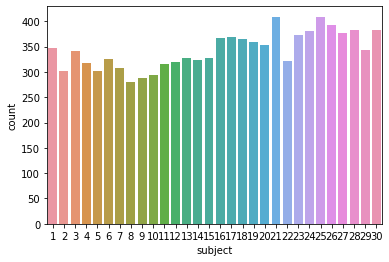

In [22]:
sns.countplot(x='subject', data=working_data)

We have a roughly equivalent number of rows per subject so we shouldn't have to worry too much about some subjects having more data than others, which could skew predictions. Now let's assume that the order of rows per subject reflects the timepoint of data acquisition. So let's add a column called "timepoint" to help us visualise the order of events. (We won't include this variable in our model as it would be too easy to simply use timepoint to predict a person's activity if all subjects performed the actions in the same order.)

In [23]:
working_data['timepoint'] = working_data.groupby(['subject']).cumcount()+1

In [24]:
working_data.head()

tGravityAcc-mean()-X  tGravityAcc-correlation()-X,Y  \
0              0.963396                       0.570222   
1              0.966561                      -0.831284   
2              0.966878                      -0.181090   
3              0.967615                      -0.991309   
4              0.968224                      -0.408330   

   tGravityAcc-correlation()-X,Z  tGravityAcc-correlation()-Y,Z  \
0                       0.439027                       0.986913   
1                      -0.865711                       0.974386   
2                       0.337936                       0.643417   
3                      -0.968821                       0.984256   
4                      -0.184840                       0.964797   

   angle(tBodyGyroMean,gravityMean)  subject  Activity  timepoint  
0                         -0.464761        1  STANDING          1  
1                         -0.732626        1  STANDING          2  
2                          0.100699        1  STANDING          3  
3                          0.640011        1  STANDING          4  
4                          0.693578        1  STANDING          5

Before we submit our features to a model, let's take a look at the variance across these sensors.

## Visualising Selected Features

Let's start by renaming the columns so that we won't have too many characters which may potentially conflict with coding when building a prediction app.

In [25]:
working_data = working_data.rename(columns={"tGravityAcc-mean()-X": "tGravityAccmeanX", "tGravityAcc-correlation()-X,Y": "tGravityAccCorrelationXY", "tGravityAcc-correlation()-X,Z": "tGravityAccCorrelationXZ", "tGravityAcc-correlation()-Y,Z": "tGravityAccCorrelationYZ", "angle(tBodyGyroMean,gravityMean)": "angletBodyGyroMeanGravityMean"}, errors="raise")

In [26]:
working_data.head()

tGravityAccmeanX  tGravityAccCorrelationXY  tGravityAccCorrelationXZ  \
0          0.963396                  0.570222                  0.439027   
1          0.966561                 -0.831284                 -0.865711   
2          0.966878                 -0.181090                  0.337936   
3          0.967615                 -0.991309                 -0.968821   
4          0.968224                 -0.408330                 -0.184840   

   tGravityAccCorrelationYZ  angletBodyGyroMeanGravityMean  subject  Activity  \
0                  0.986913                      -0.464761        1  STANDING   
1                  0.974386                      -0.732626        1  STANDING   
2                  0.643417                       0.100699        1  STANDING   
3                  0.984256                       0.640011        1  STANDING   
4                  0.964797                       0.693578        1  STANDING   

   timepoint  
0          1  
1          2  
2          3  
3          4  
4          5

Import the Plotly library to visualise our sensor data.

In [27]:
import plotly.express as px

Now let's create an interactive plot that shows what different types of movement activity look like across time and Subject. Click the type of activity you want to visualise in the Activity legend.

**tGravityAccmeanX**

In [28]:
fig = px.scatter_3d(working_data, x='subject', y='timepoint', z='tGravityAccmeanX',
              color='Activity', height=700)
fig.update_traces(mode='markers', marker_size=4, opacity=0.5)

fig.show()

**tGravityAccCorrelationXY**

In [29]:
fig = px.scatter_3d(working_data, x='subject', y='timepoint', z='tGravityAccCorrelationXY',
              color='Activity', height=700)
fig.update_traces(mode='markers', marker_size=4, opacity=0.5)

fig.show()

**tGravityAccCorrelationXZ**

In [30]:
fig = px.scatter_3d(working_data, x='subject', y='timepoint', z='tGravityAccCorrelationXZ',
              color='Activity', height=700)
fig.update_traces(mode='markers', marker_size=4, opacity=0.5)

fig.show()

**tGravityAccCorrelationYZ**

In [31]:
fig = px.scatter_3d(working_data, x='subject', y='timepoint', z='tGravityAccCorrelationYZ',
              color='Activity', height=700)
fig.update_traces(mode='markers', marker_size=4, opacity=0.5)

fig.show()

**angletBodyGyroMeanGravityMean**

In [32]:
fig = px.scatter_3d(working_data, x='subject', y='timepoint', z='angletBodyGyroMeanGravityMean',
              color='Activity', height=700)
fig.update_traces(mode='markers', marker_size=4, opacity=0.5)
fig.show()

Now that we have six features we can use to predict human movement, let's see if PyCaret can use them to discriminate activity types.

First, we need to split the data into seen and unseen sections. The seen portion will be used for training the model, and the unseen portion will be used during validation. 10% of the whole dataset will be sectioned off as unseen data.

In [30]:
data = working_data.sample(frac=0.9, random_state=786)
data_unseen = working_data.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (9269, 8)
Unseen Data For Predictions: (1030, 8)


In [31]:
data.head()

tGravityAccmeanX  tGravityAccCorrelationXY  tGravityAccCorrelationXZ  \
0          0.921683                  0.919217                 -0.764555   
1         -0.279626                 -0.316370                  0.657337   
2          0.923757                  0.848128                  0.204341   
3          0.968940                  0.135901                 -0.379885   
4          0.888280                  0.738631                  0.941210   

   tGravityAccCorrelationYZ  angletBodyGyroMeanGravityMean  subject  \
0                 -0.600517                      -0.866456       25   
1                  0.228402                       0.203255        3   
2                 -0.056279                      -0.949762        3   
3                  0.188518                      -0.923282       29   
4                  0.719470                       0.934874       27   

             Activity  timepoint  
0    WALKING_UPSTAIRS        183  
1              LAYING         75  
2             WALKING        279  
3  WALKING_DOWNSTAIRS        311  
4  WALKING_DOWNSTAIRS        348

## Setting up the Environment in PyCaret

From PyCaret documentation:
- The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

- When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

Drop the "timepoint" column as we don't want to use it to influence label prediction. This is because the order of movements across timepoints is invariant across participants. Therefore, timepoint alone could drive model predictions substantially more than our actual movement variables.

Most of the output will not be relevant for this specific example but we can make sure that the target type is registered as "MultiClass" and that the labels are correctly recognised. We can also check for the presence of missing values and inspect our Training and Test set split. Additionally, we can enable normalisation so that the features are represented as Z-scores. This may help improve model performance, though PyCaret developers recommend running multiple experiments to examine if this is indeed the case. We could also have used the setup feature to remove one feature per pair of highly co-linear variables but in our case we have already removed all multicollinear variables above.

In [32]:
from pycaret.classification import *
exp_mclf101 = setup(data = data, target = 'Activity', session_id=123, categorical_features = ['subject'], ignore_features = ['timepoint'], normalize=True)

Setup Succesfully Completed!


Now, find the model with the best peformance. PyCaret will perform 10 cross-validations per model and report the model averages in each row.

In [33]:
best = compare_models()

Let's inspect the cross-validation folds of the best performing models.

In [34]:
cat_boost = create_model('catboost')

In [35]:
lgbm = create_model('lightgbm')

Print the parameters of the LGBM model.

In [36]:
print(lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [37]:
extreme_boosting = create_model('xgboost')

Print the parameters of the extreme_boosting model.

In [38]:
print(extreme_boosting)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)


# Tune a Model

Now that we've inspected three of the best performing models, let's see if it's possible to improve their performance by tuning their hyperparameters.

From PyCaret:
- When a model is created using the create_model() function it uses the default hyperparameters to train the model. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1, Kappa, and MCC by fold for the best model.

## Cat Boosting

In [39]:
tuned_cat_boost = tune_model(cat_boost)

In [40]:
print(tuned_cat_boost)

## Light Gradient Boosting Machine

In [41]:
tuned_lgbm = tune_model(lgbm)

In [42]:
print(tuned_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=30,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
               n_estimators=100, n_jobs=-1, num_leaves=70, objective=None,
               random_state=123, reg_alpha=0.1, reg_lambda=0.5, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


## XGBoost

In [43]:
tuned_extreme_boost = tune_model(extreme_boosting)

In [44]:
print(tuned_extreme_boost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=50,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=230, n_jobs=-1, num_class=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=0)


# Plot a Model

## Confusion Matrix

Since CatBoost confusion matrices are currently not supported within PyCaret, will stick with LGBM and XGBoost.

Let's first plot the feature importance for predicting the target.

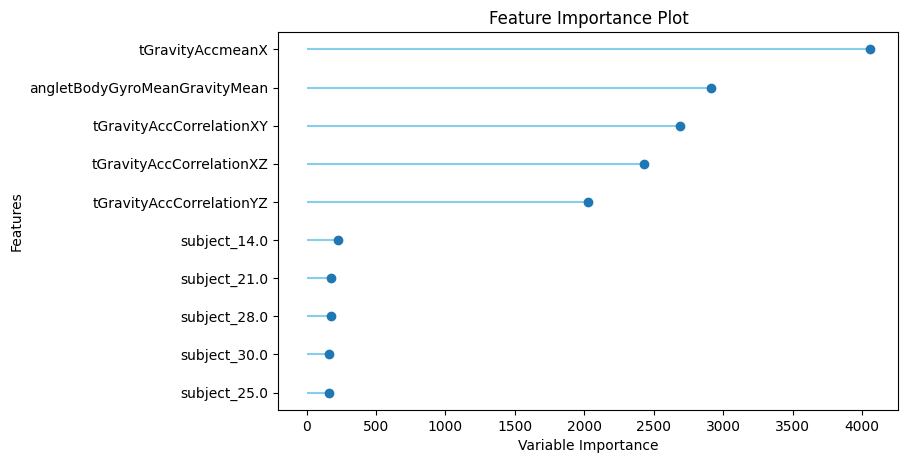

In [45]:
plot_model(lgbm, plot = 'feature')

We could also do with a confusion matrix that shows how well each class was categorised.

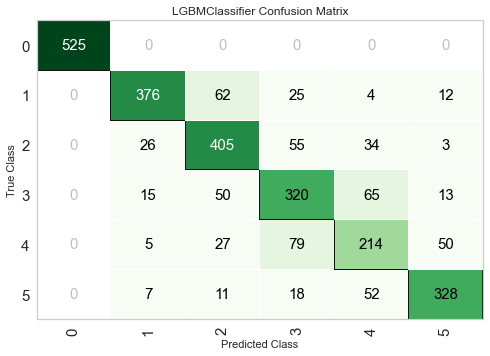

In [46]:
plot_model(lgbm, plot = 'confusion_matrix')

Now let's create a classification report for each class.

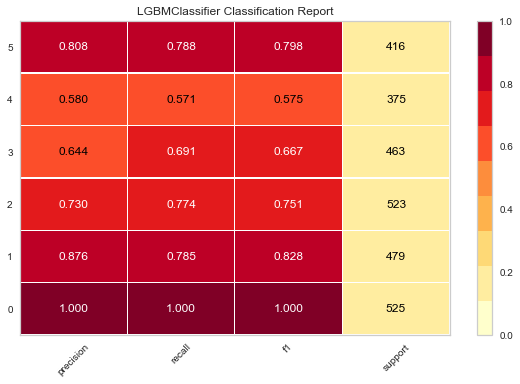

In [47]:
plot_model(lgbm, plot = 'class_report')

Now let's categorise the errors by class.

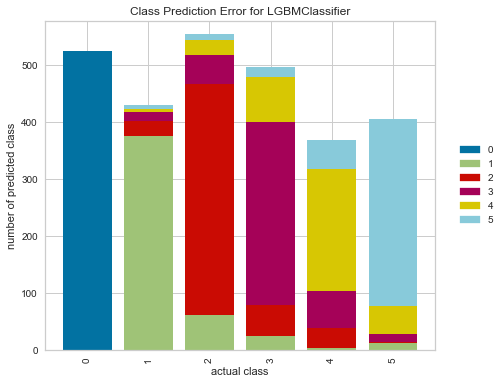

In [48]:
plot_model(lgbm, plot = 'error')

# Saving the model and creating a model pipeline

Let's finalise the LGBM model which we'll later incorporate into our web app.

In [50]:
predict_model(lgbm);

Model  Accuracy  AUC  Recall   Prec.      F1  \
0  Light Gradient Boosting Machine    0.7796    0  0.7683  0.7832  0.7807   

    Kappa    MCC  
0  0.7347  0.735

In [51]:
final_lgbm = finalize_model(lgbm)

Let's use the model to predict unseen data

In [52]:
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

tGravityAccmeanX  tGravityAccCorrelationXY  tGravityAccCorrelationXZ  \
0          0.967948                 -0.563951                  0.466471   
1          0.953606                  0.894283                  0.919808   
2          0.625774                 -0.948105                 -0.952271   
3          0.876540                 -0.891315                  0.918475   
4         -0.208633                  0.291819                 -0.555118   

   tGravityAccCorrelationYZ  angletBodyGyroMeanGravityMean  subject  Activity  \
0                  0.443097                       0.275041        1  STANDING   
1                  0.990298                      -0.240572        1  STANDING   
2                  0.973579                       0.161270        1   SITTING   
3                 -0.646516                       0.617874        1   SITTING   
4                 -0.721079                       0.263401        1    LAYING   

   timepoint     Label   Score  
0          6  STANDING  0.5276  
1         19  STANDING  0.9717  
2         38   SITTING  0.9996  
3         40   WALKING  0.4687  
4         58    LAYING  1.0000

Save the model

In [53]:
save_model(final_lgbm,'FinalLGBMModel12Oct2020')

Transformation Pipeline and Model Succesfully Saved


Load the model to predict new data.

In [54]:
saved_final_lgbm = load_model('FinalLGBMModel12Oct2020')

Transformation Pipeline and Model Successfully Loaded


Predict new data. In our case, we're using the same unseen data, so the results should be identical.

In [55]:
new_prediction = predict_model(saved_final_lgbm, data=data_unseen)

In [56]:
new_prediction.head()

tGravityAccmeanX  tGravityAccCorrelationXY  tGravityAccCorrelationXZ  \
0          0.967948                 -0.563951                  0.466471   
1          0.953606                  0.894283                  0.919808   
2          0.625774                 -0.948105                 -0.952271   
3          0.876540                 -0.891315                  0.918475   
4         -0.208633                  0.291819                 -0.555118   

   tGravityAccCorrelationYZ  angletBodyGyroMeanGravityMean  subject  Activity  \
0                  0.443097                       0.275041        1  STANDING   
1                  0.990298                      -0.240572        1  STANDING   
2                  0.973579                       0.161270        1   SITTING   
3                 -0.646516                       0.617874        1   SITTING   
4                 -0.721079                       0.263401        1    LAYING   

   timepoint     Label   Score  
0          6  STANDING  0.5276  
1         19  STANDING  0.9717  
2         38   SITTING  0.9996  
3         40   WALKING  0.4687  
4         58    LAYING  1.0000

For more information, please visit the [PyCaret](https://github.com/pycaret/pycaret/tree/master/tutorials) tutorials repo to adapt their tools for your own workflow.